# Simple Power grid example with random consumers
## Creating a co-simulation graph
We consider the following power grid taken from [a CIGRE network](http://www.cigre.org/News/Network-of-the-Future) described by the following picture:

<img src="./figures/cigre_network_lv.png" alt="Model" style="width: 500px;"/>

A model of this network have be created using pandapower and data exported as descibed in [PowerGridModel.ipynb](./PowerGridModel.ipynb)

The modeled system is the power grid with consumers that set random active and reactive power for each time step.

In [1]:
import os
from ictdeploy import Simulator as Sim

In [2]:
import json
import pandas as pd

In [3]:
#create empty simulator
sim = Sim()

### Load data for power grid `Meta-model` creation
The input values for the power grid `Node` will be the active and reactive power for each consumers.

It will be set at the level of the power grid `Meta-model` defining the `set_attrs` from the loaded data.

In [4]:
data_power_grid_folder = "PowerGridData"

loads = pd.DataFrame(json.load(open(os.path.join(data_power_grid_folder, 'load.json'))))
loads.index = map(int, loads.index)
loads.head()

,bus,const_i_percent,const_z_percent,in_service,name,p_kw,q_kvar,scaling,sn_kva,type
0,2,0.0,0.0,True,LoadR1,10.0,1.0,1.0,None,None
1,12,0.0,0.0,True,LoadR11,10.0,1.0,1.0,None,None
10,37,0.0,0.0,True,LoadC14,10.0,1.0,1.0,None,None
11,40,0.0,0.0,True,LoadC17,10.0,1.0,1.0,None,None
12,41,0.0,0.0,True,LoadC18,10.0,1.0,1.0,None,None


In [5]:
#create Meta-model

set_attrs = [n+"_p_kw" for n in loads.name]
set_attrs += [n+"_q_kvar" for n in loads.name]

sim.edit.add_meta(
        name="PowerGridMeta",
        set_attrs=set_attrs,
        get_attrs=[]
    )

'PowerGridMeta'

### Implement the power grid model in the `Node` from data
The parameters, structure, and topology of the power grid have been stored in various `.json` files.

Those `.json` files need to be loaded into the `Node` container at run time.

Therefore files to be added to the container will be defined in the creation of the `Model`.

The wrapper for the power grid `Node` can be found [here](./wrappers/power_grid_wrap.py).

In [6]:
#create Model
sim.edit.add_model(
        name="PowerGridModel",
        meta="PowerGridMeta",
        image="integrcity/ict-pandapower",
        wrapper=os.path.join("wrappers", "power_grid_wrap.py"),
        command=None,
        files=[os.path.join(data_power_grid_folder, f) for f in os.listdir(data_power_grid_folder)]
    )

'PowerGridModel'

In [7]:
#add node
sim.edit.add_node(
        name="PowerGrid",
        model="PowerGridModel",
        init_values={}
    )

'PowerGrid'

### Define consumers `Meta-model`, `Model` and `Nodes`
The wrapper for the consumers `Nodes` can be found [here](./wrappers/consumer_wrap.py).

In [8]:
#create Meta-model

sim.edit.add_meta(
        name="ConsumerMeta",
        set_attrs=[],
        get_attrs=["p_kw", "q_kvar"]
    )

'ConsumerMeta'

In [9]:
#create Model
sim.edit.add_model(
        name="ConsumerModel",
        meta="ConsumerMeta",
        image="integrcity/ict-simple",
        wrapper=os.path.join("wrappers", "consumer_wrap.py"),
        command=None,
        files=[]
    )

'ConsumerModel'

In [10]:
#add node
for n in loads.name:
    sim.edit.add_node(
        name=n,
        model="ConsumerModel",
        init_values={"loc": 5.0, "scale": 0.5},
        is_first=True
    )

In [11]:
sim.edit.nodes.tail()

,meta,model,to_set,to_get,image,wrapper,files,command,init_values,is_first,is_local
LoadR15,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True,False
LoadR16,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True,False
LoadR17,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True,False
LoadR18,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True,False
PowerGrid,PowerGridMeta,PowerGridModel,"[LoadR1_p_kw, LoadR11_p_kw, LoadC14_p_kw, Load...",[],integrcity/ict-pandapower,wrappers/power_grid_wrap.py,"[PowerGridData/load.json, PowerGridData/ext_gr...",None,{},False,False


### Links
The active and reactive power `Links` bewteen each of the consumers and the power grid can be created using `Simulator.edit.add_multiple_links_between_two_nodes()` and looping through all the consumers as follow:

In [12]:
for n in loads.name:
    sim.edit.add_multiple_links_between_two_nodes(
        get_node=n, 
        set_node="PowerGrid", 
        get_attrs=["p_kw", "q_kvar"],
        set_attrs=["{}_p_kw".format(n), "{}_q_kvar".format(n)],
        units=["p_kw", "q_kvar"]
    )

In [13]:
sim.edit.links.head()

,get_attr,get_node,set_attr,set_node
0,p_kw,LoadR1,LoadR1_p_kw,PowerGrid
1,q_kvar,LoadR1,LoadR1_q_kvar,PowerGrid
2,p_kw,LoadR11,LoadR11_p_kw,PowerGrid
3,q_kvar,LoadR11,LoadR11_q_kvar,PowerGrid
4,p_kw,LoadC14,LoadC14_p_kw,PowerGrid


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


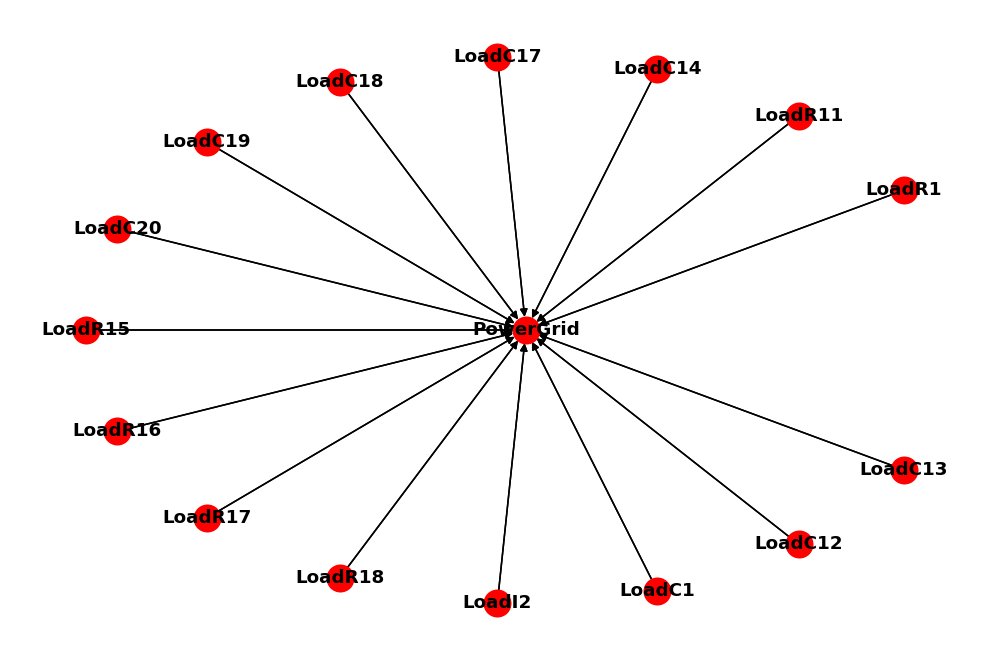

In [23]:
%matplotlib notebook
plt.figure(figsize=(9, 6))
g = sim.edit.graph
# Draw the graph with a Kamada-Kawai force-directed layout.
nx.draw_kamada_kawai(g, with_labels=True, font_weight='bold')

## Simulation parameters
Based on the created co-simulation graph, we can now create `Groups`, `Sequence` and `Steps` for the simulation as follow:

In [16]:
grp0 = sim.create_group(*[n for n in loads.name])
grp1 = sim.create_group("PowerGrid")

In [17]:
sim.create_sequence(grp0, grp1)
sim.create_steps([60] * 5)

## Running simulation
Everything is ready, we just have to run the simulation using `Simulator.run_simulation()`

In [18]:
logs = sim.run_simulation(server="server.py")
print(logs.keys())

dict_keys(['aux', 'orc', 'nodes'])


In [19]:
for l in sim.get_logs(logs["orc"]):
    if "INFO" in l:
        print(l)

INFO - 2018-06-13 11:29:42,276 - Connected to 172.17.01/obnl_vhost
INFO - 2018-06-13 11:29:42,304 - scheduler initialised.
INFO - 2018-06-13 11:29:43,558 - Simulator LoadC1 is connected.
INFO - 2018-06-13 11:29:43,632 - Simulator LoadC12 is connected.
INFO - 2018-06-13 11:29:44,241 - Simulator LoadC13 is connected.
INFO - 2018-06-13 11:29:44,729 - Simulator LoadC14 is connected.
INFO - 2018-06-13 11:29:45,209 - Simulator LoadC17 is connected.
INFO - 2018-06-13 11:29:45,743 - Simulator LoadC18 is connected.
INFO - 2018-06-13 11:29:46,392 - Simulator LoadC19 is connected.
INFO - 2018-06-13 11:29:46,856 - Simulator LoadC20 is connected.
INFO - 2018-06-13 11:29:47,388 - Simulator LoadI2 is connected.
INFO - 2018-06-13 11:29:47,867 - Simulator LoadR1 is connected.
INFO - 2018-06-13 11:29:48,340 - Simulator LoadR11 is connected.
INFO - 2018-06-13 11:29:48,818 - Simulator LoadR15 is connected.
INFO - 2018-06-13 11:29:49,381 - Simulator LoadR16 is connected.
INFO - 2018-06-13 11:29:49,905 - Si

## Retrieving results

Now that the simulation is finished, we can connect to the database of results and list all the available stored values as follow: 

In [20]:
sim.results.connect_to_results_db()
res = sim.results.list_of_available_results
res.loc[res["IN/OUT"] == "X"]

,IN/OUT,Node,Attribute
33,X,PowerGrid,Feeder_p_kw
61,X,PowerGrid,Feeder_q_kvar


"X" defines the stored values describing internal state that are not exchanged between `Nodes`, here the active and reactive power consumed by the feeder delivering energy to all the consumers.

In [21]:
results = sim.results.get_results_by_pattern("X*PowerGrid*")
results.keys()

dict_keys(['X||PowerGrid||Feeder_p_kw', 'X||PowerGrid||Feeder_q_kvar'])

<IPython.core.display.Javascript object>


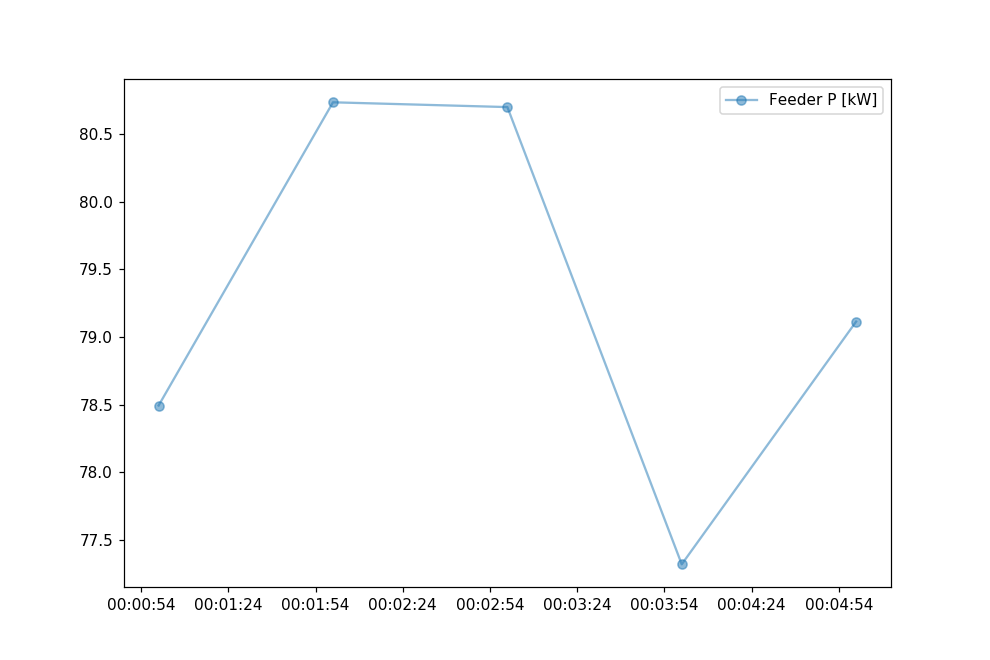

In [22]:
%matplotlib notebook

plt.figure(figsize=(9, 6))
plt.plot(-1*results['X||PowerGrid||Feeder_p_kw'], "-o", label="Feeder P [kW]", alpha=0.5)
plt.legend()